# Subcellular location


## Notes on pairs of compartments to exclude
- [Nucleus and Nucleoplasm are mutualy exclusive definitions](https://www.proteinatlas.org/learn/dictionary/cell/nucleus)
- [The Centrosome is a microtubule organizing center](https://www.proteinatlas.org/learn/dictionary/cell/microtubule+organizing+center) 
- [There is vesicles as a general term and endosomes, lysosomes, perioxisomes and lipid droplets as specific instances](https://www.proteinatlas.org/learn/dictionary/cell/vesicles+7)

In [1]:
import os

import numpy as np
from scipy import stats
from scipy import odr
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

from custom_settings import *
from utils import *

%matplotlib inline

In [2]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500

In [3]:
hpa = load_subcellular_location()
hi_iii = load_nw_hi_iii()
space_iii = load_space_iii()
pcg = load_protein_coding_genome()
hpa = hpa[hpa.index.isin(pcg)]
compartments = hpa.columns
hpa['in_hi_iii'] = (hpa.index.isin(hi_iii['ensembl_gene_id_a'].unique()) |
                    hpa.index.isin(hi_iii['ensembl_gene_id_b'].unique()))

In [4]:
hi_iii = hi_iii.loc[hi_iii['ensembl_gene_id_a'] != hi_iii['ensembl_gene_id_b'], :]

In [5]:
hpa[compartments].sum(axis=0).sort_values(ascending=False)

in_Cytosol                          3940
in_Nucleoplasm                      3551
in_Nucleus                          1819
in_Vesicles                         1662
in_Plasma membrane                  1403
in_Mitochondria                     1008
in_Nucleoli                          957
in_Golgi apparatus                   906
in_Nuclear bodies                    461
in_Endoplasmic reticulum             429
in_Nuclear speckles                  420
in_Centrosome                        307
in_Cell Junctions                    278
in_Nuclear membrane                  260
in_Nucleoli fibrillar center         250
in_Microtubules                      225
in_Actin filaments                   211
in_Intermediate filaments            163
in_Microtubule organizing center     129
in_Focal adhesion sites              125
in_Cytokinetic bridge                100
in_Cytoplasmic bodies                 55
in_Midbody                            37
in_Lipid droplets                     33
in_Mitotic spind

/Users/lukelambourne/Work/HuRI_paper/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Number of proteins')

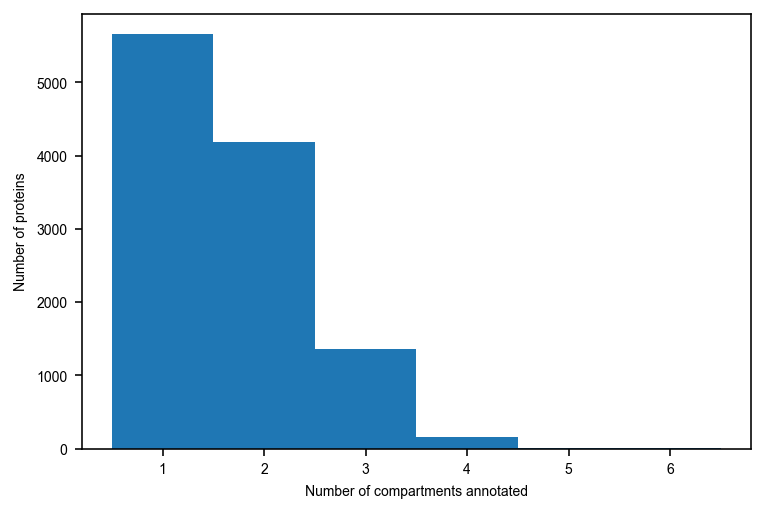

In [6]:
hpa[compartments].sum(axis=1).plot('hist', bins=6, range=(0.5, 6.5))
plt.xlabel('Number of compartments annotated')
plt.ylabel('Number of proteins')

In [7]:
pairs_to_skip = (set(['in_Nucleoplasm', 'in_Nucleus']),
                 set(['in_Nucleoplasm', 'in_Nucleoli']),
                 set(['in_Nuclear speckles', 'in_Nucleus']),
                 set(['in_Nucleoli fibrillar center', 'in_Nucleoli']),
                 set(['in_Microtubule organizing center', 'in_Centrosome']))
results = []
genes_in_compartments = [(set(hpa.loc[hpa[c], :].index), c) for c in compartments]
genes_all_hpa = set(hpa.index)
comp_in_hi_iii = [(g, c) for g, c in genes_in_compartments if (hi_iii['ensembl_gene_id_a'].isin(g).sum() + 
                                                               hi_iii['ensembl_gene_id_b'].isin(g).sum() > 0) and
                                                               len(g) >= 100]
    
for i, (genes_a, comp_a) in enumerate(comp_in_hi_iii):
    for genes_b, comp_b in comp_in_hi_iii[i + 1:]:
        if set([comp_a, comp_b]) in pairs_to_skip:
            print('Skipping pair')
            continue
        genes_a_not_b = genes_a.difference(genes_b)
        genes_b_not_a = genes_b.difference(genes_a)
        genes_not_a_not_b = genes_all_hpa.difference(genes_a.union(genes_b))
        ppis_a_b = ((hi_iii['ensembl_gene_id_a'].isin(genes_a_not_b) & 
                     hi_iii['ensembl_gene_id_b'].isin(genes_b_not_a)) |
                    (hi_iii['ensembl_gene_id_a'].isin(genes_b_not_a) & 
                     hi_iii['ensembl_gene_id_b'].isin(genes_a_not_b))).sum()
        ppis_a_not_b = ((hi_iii['ensembl_gene_id_a'].isin(genes_a_not_b) & 
                         hi_iii['ensembl_gene_id_b'].isin(genes_not_a_not_b)) |
                        (hi_iii['ensembl_gene_id_a'].isin(genes_not_a_not_b) & 
                         hi_iii['ensembl_gene_id_b'].isin(genes_a_not_b))).sum()
        ppis_b_not_a = ((hi_iii['ensembl_gene_id_a'].isin(genes_not_a_not_b) & 
                         hi_iii['ensembl_gene_id_b'].isin(genes_b_not_a)) |
                        (hi_iii['ensembl_gene_id_a'].isin(genes_b_not_a) & 
                         hi_iii['ensembl_gene_id_b'].isin(genes_not_a_not_b))).sum()
        ppis_not_a_not_b = (hi_iii['ensembl_gene_id_a'].isin(genes_not_a_not_b) & 
                            hi_iii['ensembl_gene_id_b'].isin(genes_not_a_not_b)).sum()
        # density correction due to half the combinations minus the self-interactions
        n = len(genes_not_a_not_b)
        corr_factor = (2 * n**2) / (n**2 - n)
        lor_ppis = np.log(((ppis_not_a_not_b * corr_factor + 0.5) / 
                           (ppis_b_not_a + 0.5)) /
                          ((ppis_a_not_b + 0.5) / 
                           (ppis_a_b + 0.5)))
        err_ppis = np.sqrt(1. / (ppis_a_not_b + 0.5) +
                           1. / (ppis_a_b + 0.5) +
                           1. / (ppis_not_a_not_b + 0.5) +
                           1. / (ppis_b_not_a + 0.5))
        lor_comp = np.log(((len(genes_all_hpa.difference(genes_a.union(genes_b))) + 0.5) / 
                           (len(genes_a_not_b)) + 0.5) /
                          ((len(genes_b_not_a) + 0.5) /
                           (len(genes_a.intersection(genes_b)) + 0.5)))
        err_comp = np.sqrt(1. / (len(genes_all_hpa.difference(genes_a.union(genes_b))) + 0.5) +
                           1. / (len(genes_a_not_b) + 0.5) +
                           1. / (len(genes_b_not_a) + 0.5) +
                           1. / (len(genes_a.intersection(genes_b)) + 0.5))
        results.append([comp_a,
                        comp_b,
                        ppis_a_b,
                        lor_comp,
                        lor_ppis,
                        err_comp,
                        err_ppis])
results = pd.DataFrame(data=results,
                       columns=['compartment_a',
                                'compartment_b',
                                'n_ppis_a_b',
                                'log_odds_ratio_compartments',
                                'log_odds_ratio_ppis',
                                'err_compartments',
                                'err_ppis'])


def linear_with_intercept(B, x):
    return B[0]*x + B[1]

linear = odr.Model(linear_with_intercept)
mydata = odr.RealData(results['log_odds_ratio_ppis'].values,
                      results['log_odds_ratio_compartments'].values,
                      sx=results['err_ppis'].values,
                      sy=results['err_compartments'].values)
myodr = odr.ODR(mydata, linear, beta0=[0.01, 0.])
myoutput = myodr.run()
observed_slope = myoutput.beta[0]
myoutput.pprint()
observed_slope_z = myoutput.beta[0] / myoutput.sd_beta[0]

Skipping pair
Skipping pair
Skipping pair
Skipping pair
Skipping pair
Beta: [11.37164147 -0.91963053]
Beta Std Error: [2.20089152 0.14473173]
Beta Covariance: [[ 1.83189394 -0.05470206]
 [-0.05470206  0.00792192]]
Residual Variance: 2.644216108767308
Inverse Condition #: 0.5439966149838449
Reason(s) for Halting:
  Sum of squares convergence


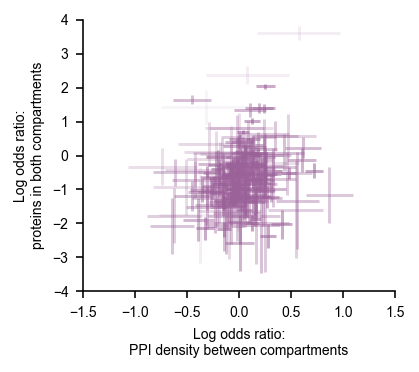

In [8]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.8, 2.5)
min_e = results['err_ppis'].min()
max_e = results['err_ppis'].max()
rng = max_e - min_e
for i, result in results.iterrows():
    a = 0.6 * (1. - (result['err_ppis'] - min_e) / rng)
    plt.errorbar(x=[result['log_odds_ratio_ppis']],
                 y=[result['log_odds_ratio_compartments']],
                 xerr=[result['err_ppis']],
                 yerr=[result['err_compartments']],
                 fmt='none',
                 color=HURI_COLOR,
                 alpha=a)
plt.xlabel('Log odds ratio:\nPPI density between compartments')
plt.ylabel('Log odds ratio:\nproteins in both compartments')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((-1.5, 1.5))
ax.set_ylim((-4., 4.))
for fmt in FORMATS:
    plt.savefig('../figures/subcellular_compartments_corr' + fmt,
                bbox_inches='tight')

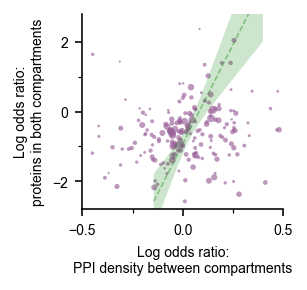

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.8, 1.8)
min_e = results['err_ppis'].min()
max_e = results['err_ppis'].max()
rng_e = max_e - min_e
# scatter size is in points^2, Journal says minimum point size is 0.25
max_size = 15.
min_size = 1.
size = [max_size * (1/e - 1/max_e) / (1/min_e - 1/max_e) + min_size for e in results['err_ppis'].values]
ax.scatter(x=results['log_odds_ratio_ppis'].values,
           y=results['log_odds_ratio_compartments'].values,
           s=size,
           color=HURI_COLOR,
           alpha=0.65,
           linewidths=0)
ymin = results['log_odds_ratio_compartments'].min()
ymax = results['log_odds_ratio_compartments'].max()
xmin = (ymin - myoutput.beta[1]) / myoutput.beta[0]
xmax = (ymax - myoutput.beta[1]) / myoutput.beta[0]
ax.plot([xmin, xmax], [ymin, ymax],
        zorder=-10,
        alpha=0.4,
        linestyle='--',
        linewidth=0.75,
        color='green')
# scipy 1.2.0 gives the wrong covariance matrix!
# https://github.com/scipy/scipy/issues/6842
cov_matrix = myoutput.cov_beta * myoutput.res_var
xgrid = np.linspace(xmin, xmax, 1000)
ygrid = xgrid * myoutput.beta[0] + myoutput.beta[1]
se = np.array([np.sqrt(cov_matrix[1, 1] + 2 * x * cov_matrix[0, 1] + x ** 2 * cov_matrix[0, 0]) 
               for x in xgrid])
ax.fill_between(xgrid, ygrid - 1.96 * se, ygrid + 1.96 * se,
                alpha=0.2,
                color='green',
                linewidth=0)
ax.set_xlim(-1, 1)
ax.set_xticks(np.arange(-1., 1.01, 0.5))
ax.set_xticks(np.arange(-0.75, 0.76, 0.5), minor=True)
ax.set_yticks(np.arange(-2., 4.01, 2))
ax.set_yticks(np.arange(-3, 5.01, 2), minor=True)
ax.set_ylim(-3., 4.)
ax.set_xlabel('Log odds ratio:\nPPI density between compartments',
              fontsize=7)
ax.set_ylabel('Log odds ratio:\nproteins in both compartments',
              fontsize=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(-2.8, 2.8)
ax.set_xlim(-0.5, 0.5)
for fmt in FORMATS:
    plt.savefig('../figures/subcellular_compartments_corr_with_fit' + fmt,
                bbox_inches='tight')

In [10]:
def calculate_slope_for_random_network(nw, verbose=False, draw_plot=False, debug=False):
    nw = pd.DataFrame(data=[[nw.vs[e.source]['name'], nw.vs[e.target]['name']] for e in nw.es],
                      columns=['ensembl_gene_id_a', 'ensembl_gene_id_b'])
    lor_ppis, err_ppis = [], []
    for i, (genes_x, comp_x) in enumerate(comp_in_hi_iii):
        for genes_y, comp_y in comp_in_hi_iii[i + 1:]:
            if set([comp_x, comp_y]) in pairs_to_skip:
                continue
            genes_x_not_y = genes_x.difference(genes_y)
            genes_y_not_x = genes_y.difference(genes_x)
            genes_x_and_y = genes_x.union(genes_y)
            genes_not_x_not_y = genes_all_hpa.difference(genes_x_and_y)
            gene_a_in_comp_x = nw['ensembl_gene_id_a'].isin(genes_x_not_y)
            gene_b_in_comp_x = nw['ensembl_gene_id_b'].isin(genes_x_not_y)
            gene_a_in_comp_y = nw['ensembl_gene_id_a'].isin(genes_y_not_x)
            gene_b_in_comp_y = nw['ensembl_gene_id_b'].isin(genes_y_not_x)
            gene_a_in_neither_comp_x_or_y = nw['ensembl_gene_id_a'].isin(genes_not_x_not_y)
            gene_b_in_neither_comp_x_or_y = nw['ensembl_gene_id_b'].isin(genes_not_x_not_y)
            ppis_a_b = ((gene_a_in_comp_x & gene_b_in_comp_y) |
                        (gene_a_in_comp_y & gene_b_in_comp_x)).sum()
            ppis_a_not_b = ((gene_a_in_comp_x & gene_b_in_neither_comp_x_or_y) |
                            (gene_a_in_neither_comp_x_or_y & gene_b_in_comp_x)).sum()
            ppis_b_not_a = ((gene_a_in_neither_comp_x_or_y & gene_b_in_comp_y) |
                            (gene_a_in_comp_y & gene_b_in_neither_comp_x_or_y)).sum()
            ppis_not_a_not_b = (nw['ensembl_gene_id_a'].isin(genes_not_x_not_y) & 
                                nw['ensembl_gene_id_b'].isin(genes_not_x_not_y)).sum()
            # density correction due to half the combinations minus the self-interactions
            n = len(genes_not_x_not_y)
            corr_factor = (2 * n**2) / (n**2 - n)
            lor_ppis.append(np.log(((ppis_not_a_not_b * corr_factor + 0.5) / 
                                    (ppis_b_not_a + 0.5)) /
                                   ((ppis_a_not_b + 0.5) / 
                                    (ppis_a_b + 0.5))))
            err_ppis.append(np.sqrt(1. / (ppis_a_not_b + 0.5) +
                                    1. / (ppis_a_b + 0.5) +
                                    1. / (ppis_not_a_not_b + 0.5) +
                                    1. / (ppis_b_not_a + 0.5)))
    if results.shape[0] != len(lor_ppis):
        raise UserWarning('Something went wrong')
    mydata = odr.RealData(np.array(lor_ppis),
                          results['log_odds_ratio_compartments'].values,
                          sx=np.array(err_ppis),
                          sy=results['err_compartments'].values)
    myodr = odr.ODR(mydata, linear, beta0=[0.01, 0.])
    myoutput = myodr.run()
    slope = myoutput.beta[0]
    pcc = stats.pearsonr(lor_ppis,
                         results['log_odds_ratio_compartments'].values)[0]
    if verbose:
        myoutput.pprint()
        print('Pearsons r:', pcc)
    if debug:
        print('log odds ppis:', lor_ppis)
        print('error on log odds ppis:', err_ppis)
    if draw_plot:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(2.8, 2.5)
        min_e = min(err_ppis)
        max_e = max(err_ppis)
        rng = max_e - min_e
        for i, result in results.iterrows():
            a = 0.6 * (1. - (err_ppis[i] - min_e) / rng)
            plt.errorbar(x=[lor_ppis[i]],
                         y=[result['log_odds_ratio_compartments']],
                         xerr=[err_ppis[i]],
                         yerr=[result['err_compartments']],
                         fmt='none',
                         color=RRS_COLOR,
                         alpha=a)
        ax.set_xlabel('Log odds ratio:\nPPI density between compartments')
        ax.set_ylabel('Log odds ratio:\nproteins in both compartments')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_title('Random network')
        ax.set_xlim((-1.5, 1.5))
        ax.set_ylim((-4., 4.))
    return myoutput.beta[0] / myoutput.sd_beta[0]

Beta: [11.37164147 -0.91963053]
Beta Std Error: [2.20089152 0.14473173]
Beta Covariance: [[ 1.83189394 -0.05470206]
 [-0.05470206  0.00792192]]
Residual Variance: 2.644216108767308
Inverse Condition #: 0.5439966149838449
Reason(s) for Halting:
  Sum of squares convergence
Pearsons r: 0.1819563780434056
CPU times: user 12.5 s, sys: 167 ms, total: 12.6 s
Wall time: 13.3 s


5.166834154529622

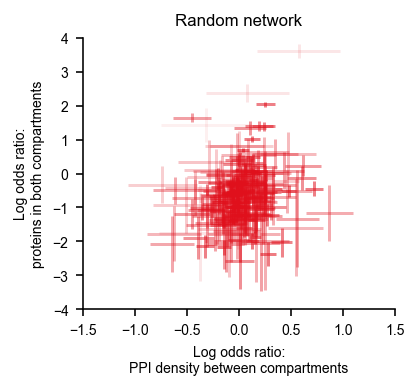

In [11]:
%%time
# check that this returns same value
calculate_slope_for_random_network(format_network(hi_iii,
                                                  fmt='igraph',
                                                  id_type='ensembl_gene_id'),
                                   verbose=True,
                                   draw_plot=True,
                                   debug=False)

In [12]:
rand_nws = generate_random_networks(format_network(hi_iii, 
                                                   fmt='igraph',
                                                   id_type='ensembl_gene_id'),
                                     n=1000)

100%|██████████| 1000/1000 [06:57<00:00,  2.39it/s]


In [13]:
intermediate_file_path = '../output/slopes_of_random_nw.txt'
if os.path.exists(intermediate_file_path):
    with open(intermediate_file_path, 'w') as f:
        rand_slopes = list(f.read())
else:
    rand_slopes = [calculate_slope_for_random_network(nw) for nw in tqdm(rand_nws)]
    with open(intermediate_file_path, 'w') as f:
        f.write(str(rand_slopes))

100%|██████████| 1000/1000 [12:10:44<00:00, 43.84s/it]     


FileNotFoundError: [Errno 2] No such file or directory: '../output/slopes_of_random_nw.txt'

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(1.3, 1.3)
ax.hist(rand_slopes,
        range=(-10, 10),
        weights=[1 / len(rand_slopes)] * len(rand_slopes),
        bins=20,
        label='Random networks',
        color='grey')
ax.annotate(s='HI-III-19',
            xy=(observed_slope_z, 0.),
            xytext=(observed_slope_z, ax.get_ylim()[1] * 0.5),
            ha='center',
            color=HURI_COLOR,
            arrowprops={'arrowstyle': 'simple',
                        'color': HURI_COLOR})
ax.set_xlabel('Regression slope Z-value',
              fontsize=6)
ax.set_ylabel('Fraction of random networks',
              fontsize=6)
ax.set_xlim(-6, 6)
ax.set_xticks(range(-6, 7), minor=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if observed_slope_z > max(rand_slopes):
    print('p < {:E}'.format(1. / len(rand_slopes)))
else:
    print('p = {:E}'.format())
plt.savefig('../figures/subcellular_compartments_significance.pdf',
            bbox_inches='tight')